In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# general libraries
import os  # make folders for file output
import h5py as h5
import json

from analysis import *
from general_utils import *
from scalebars import *

In [2]:
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
# data_path = "/mnt/Data/NEURONoutput/sac_net/committee_runs/"
data_path = "/mnt/Data/NEURONoutput/sac_net/test_sigmoid/"
vc_path = os.path.join(data_path, "voltage_clamp/")
spk_path = os.path.join(data_path, "spiking/")
conds = ["control", "non_ds_ach_50pr"]
dir_labels = [225, 270, 315, 0, 45, 90, 135, 180]

vc_data = {c: load_sac_rho_data(os.path.join(vc_path, c + "/")) for c in conds}
spk_data = {c: load_sac_rho_data(os.path.join(spk_path, c + "/")) for c in conds}

In [4]:
transmitters = [k for k in vc_data["control"]["0.90"][0]["soma"].keys()]
vc_control_params = vc_data["control"]["0.90"][0]["params"]

vc_trial_avgs = {
    cond: {
        rho: {
            n: {trans: np.mean(rec, axis=0) for trans, rec in net["soma"].items()}
            for n, net in nets.items()
        }
        for rho, nets in rhos.items()      
    }
    for cond, rhos in vc_data.items()
}
    
vc_net_avgs = {
    cond: {
        rho: {
            trans: np.mean([net[trans] for net in nets.values()], axis=0)
            for trans in transmitters
        }
        for rho, nets in rhos.items()
    }
    for cond, rhos in vc_trial_avgs.items()
}

vc_xaxis = np.arange(
    int(vc_control_params["tstop"] / vc_control_params["dt"]) + 1
) * vc_control_params["dt"]

In [5]:
spk_control_params = spk_data["control"]["1.00"][0]["params"]
spk_xaxis = np.arange(
    int(spk_control_params["tstop"] / spk_control_params["dt"]) + 1
) * spk_control_params["dt"]

<IPython.core.display.Javascript object>


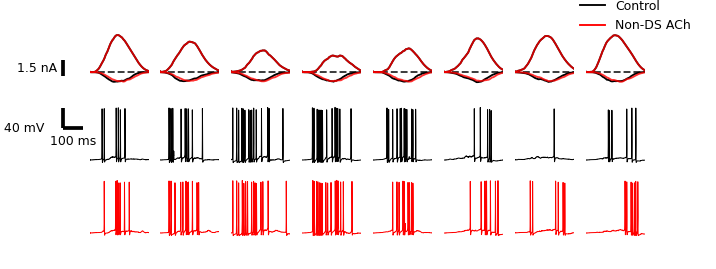

In [6]:
net_idx = 0
tr_idx = 1
conductance_mode = False

net_avg_fig, net_avg_ax = plt.subplots(
    3, len(dir_labels), sharex=True, sharey="row", figsize=(8, 3))

if conductance_mode:
    for i, ax in enumerate(net_avg_ax[0]):
        ax.plot(
            vc_xaxis, vc_net_avgs["control"]["0.90"]["E"][i] * -1,
            c="black", linewidth=0.8
        )
        ax.plot(
            vc_xaxis, vc_net_avgs["non_ds_ach_50pr"]["0.90"]["E"][i] * -1,
            c="red", alpha=0.8, linewidth=0.8
        )
else:
    for i, ax in enumerate(net_avg_ax[0]):
        ax.plot([vc_xaxis[0], vc_xaxis[-1]], [0., 0.], c="black", linestyle="--", alpha=0.8)
        ax.plot(vc_xaxis, vc_net_avgs["control"]["0.90"]["E"][i], c="black")
        ax.plot(vc_xaxis, vc_net_avgs["control"]["0.90"]["GABA"][i], c="black")
        ax.plot(vc_xaxis, vc_net_avgs["non_ds_ach_50pr"]["0.90"]["E"][i], c="red", alpha=0.8)
        ax.plot(vc_xaxis, vc_net_avgs["non_ds_ach_50pr"]["0.90"]["GABA"][i], c="red", alpha=0.8)


for i, (ctrl_ax, nonds_ax) in enumerate(zip(net_avg_ax[1], net_avg_ax[2])):
    ctrl_ax.plot(
        spk_xaxis, spk_data["control"]["1.00"][net_idx]["soma"]["Vm"][tr_idx, i],
        c="black", linewidth=.8,
    )
    nonds_ax.plot(
        spk_xaxis, spk_data["non_ds_ach_50pr"]["1.00"][net_idx]["soma"]["Vm"][tr_idx, i],
        c="red", linewidth=.8,
    )
    
    
clean_axes(net_avg_ax, remove_spines=["left", "right", "top", "bottom"])
# these currents seem crazy, try re-running of the model with weaker weights and higher
# active conductances.
add_scalebar(
    net_avg_ax[0][0], 
    matchx=False, 
    matchy=False, 
    sizey=1.5 if not conductance_mode else 0.5,
    labely="1.5 nA" if not conductance_mode else "500 pA",
#     labely="150 pA",
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(40, 200),
)
add_scalebar(
    net_avg_ax[1][0], 
    matchx=False, 
    matchy=False, 
    sizex=100, 
    sizey=40, 
    labelx="100 ms",
    labely="40 mV",
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(50, 140),
)
# line labels
net_avg_ax[0][-1].plot([], [], c="black", label="Control")
net_avg_ax[0][-1].plot([], [], c="red", label="Non-DS ACh")
net_avg_fig.legend(frameon=False, loc="upper right", bbox_to_anchor=(0.98, 1.04))

if conductance_mode:
    net_avg_ax[0][-1].set_ylim(0, 2)
else:
    net_avg_ax[0][-1].set_ylim(-2, 4)
net_avg_ax[0][-1].set_xlim(10, 300)

net_avg_fig.savefig(os.path.join(data_path, "vc_spk_non-ds.svg"), bbox_inches="tight")
net_avg_fig.show()

In [7]:
upward_e_avgs = vc_net_avgs["control"]["0.90"]["E"] * -1
time_offsets = np.array([
    find_rise_bsln(d, bsln_start=0, bsln_end=1, offset=0.03, step=1) for d in upward_e_avgs
]) * vc_control_params["dt"]
align_offsets = np.max(time_offsets) - time_offsets

print("E field offsets (ms):", time_offsets)
print("alignment_shifts (ms):", align_offsets)

E field offsets (ms): [48.3 29.8 14.5 43.8 54.9 35.6 27.6 52.1]
alignment_shifts (ms): [ 6.6 25.1 40.4 11.1  0.  19.3 27.3  2.8]


<IPython.core.display.Javascript object>


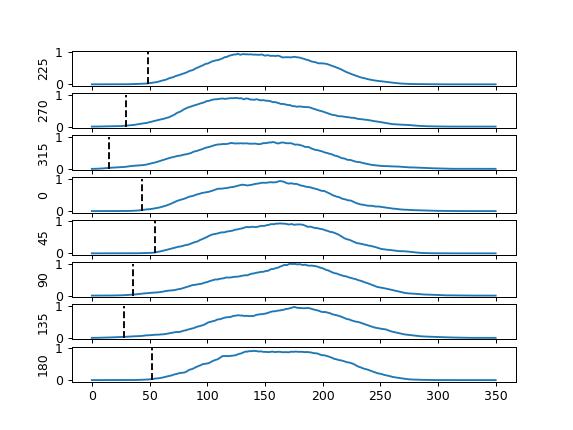

In [8]:
ff, aa = plt.subplots(8)
for ax, d, avg, off in zip(aa, dir_labels, upward_e_avgs, time_offsets):
    ax.plot(vc_xaxis, avg)
    ax.plot([off, off], [0, 1], linestyle="--", c="black")
    ax.set_ylabel(d)

<IPython.core.display.Javascript object>


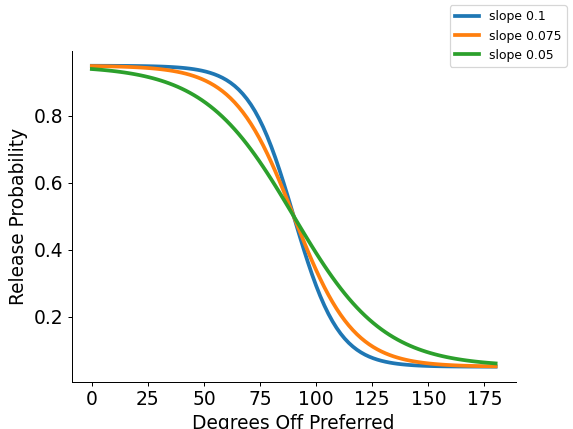

In [9]:
def sigmoid (d, n, p, offset=90, slope=0.075): 
    return p + (n - p) * (1 - 1 / (1 + np.exp((d - offset) * slope)))

dir_range = np.linspace(0, 180, 100) 
prob_p1 = np.squeeze(sigmoid(dir_range, 0.05, 0.95, slope=0.1))
prob_p075 = np.squeeze(sigmoid(dir_range, 0.05, 0.95))
prob_p05 = np.squeeze(sigmoid(dir_range, 0.05, 0.95, slope=0.05))

sigmoid_fig, sigmoid_ax = plt.subplots(1)
sigmoid_ax.plot(dir_range, prob_p1, linewidth=3, label="slope 0.1")
sigmoid_ax.plot(dir_range, prob_p075, linewidth=3, label="slope 0.075")
sigmoid_ax.plot(dir_range, prob_p05, linewidth=3, label="slope 0.05")
sigmoid_ax.set_ylabel("Release Probability", fontsize=15)
sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
clean_axes(sigmoid_ax, ticksize=15)
sigmoid_fig.savefig(os.path.join(data_path, "prob_sigmoid.svg"), bbox_inches="tight")
sigmoid_fig.legend()
sigmoid_fig.show()